In [48]:
from sklearn import datasets

X,y = sklearn.datasets.make_moons(n_samples=1000, shuffle=True, noise=1, random_state=None)

In [49]:
X.shape,y.shape

((1000, 2), (1000,))

In [50]:
import seaborn as sns

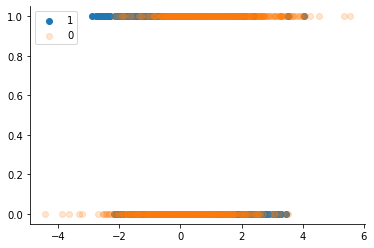

In [51]:
import matplotlib.pyplot as plt
plt.scatter(X[:,1],y,label='1')
plt.scatter(X[:,0],y,label='0',alpha=0.2)
plt.legend()
sns.despine()

In [52]:
from sklearn.model_selection import train_test_split

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [37]:
len(X_train)

750

In [13]:
import numpy as np
import jax

In [14]:
def new_model(in_dim, h_dim, out_dim):
    w = {
        1: jax.random.normal(jax.random.PRNGKey(42),shape=(in_dim, h_dim)) / np.sqrt(in_dim),
        2: jax.random.normal(jax.random.PRNGKey(42), shape=(h_dim,out_dim)) / np.sqrt(h_dim)
    }

    b = {
        1: np.zeros(h_dim),
        2: np.zeros(out_dim)
    }

    return w, b


def relu(a):

    a[a < 0] = 0
    return a


def sigmoid(a):

    return 1 / (1 + np.exp(-a))


def diff_sigmoid(a):

    return sigmoid(a) * (1 - sigmoid(a))


def diff_relu(a):

    a[a < 0] = 0
    a[a > 0] = 1
    return a


def feed_forward(p, w, b):

    a = {}
    z = {}

    z[2] = np.dot(p, w[1]) + b[1]
    a[2] = relu(z[2])
    z[3] = sigmoid(np.dot(a[2], w[2]) + b[2])

    return a, z


def cost_mse(a, y):

    return np.mean((a - y)**2)


def diff_cost_mse(a, y):
    return a - y


def bpe_delta(a, y):
    "a : Prediction, y: Ground Truth"
    return diff_cost_mse(a, y) * diff_sigmoid(a)


class NeuralNetwork:
    def __init__(self, in_dim, h_dim, out_dim, learning_rate=1e-4):

        self.w, self.b = new_model(in_dim, h_dim, out_dim)
        self.x = None
        self.a = None  # activations
        self.z = None  # xi * wi + bi
        self.learning_rate = learning_rate

    def feed_forward(self, p):

        self.x = p
        self.a, self.z = feed_forward(p, self.w, self.b)

    def backprop(self, labels):
        """
        Backpropagate the error and update the weights and biases
        labels: (array) Ground truth vector.
        """
        # partial derivative with respect to layer 2
        delta3 = bpe_delta(self.z[3], labels)

        # dc_db2 = delta3
        dc_dw2 = np.dot(self.a[2].T, delta3)

        # partial derivative with respect to layer 1
        delta2 = np.dot(delta3, self.w[2].T) * diff_relu(self.z[2])

        # dc_db1 = delta2
        dc_dw1 = np.dot(self.x.T, delta2)

        # update weights and biases
        self.w[2] -= self.learning_rate * dc_dw2
        self.b[2] -= self.learning_rate * np.mean(delta3, 0)
        self.w[1] -= self.learning_rate * dc_dw1
        self.b[1] -= self.learning_rate * np.mean(delta2, 0)

    def stats(self):
        """
        Prints some weights and biases
        """
        for i in range(1, 3):
            print("Weights layer {}:\n".format(i), self.w[i], "\nBiases layer {}:\n".format(i), self.b[i], "\n")

    def fit(self, x, labels, batch_size, epochs):

        for i in range(epochs):
            # Shuffle the data
            seed = np.arange(x.shape[0])
            # np.random.shuffle(seed)
            x_ = x[seed]
            labels_ = labels[seed]

            for j in range(x.shape[0] // batch_size):
                self.feed_forward(x_[j * batch_size: (j + 1) * batch_size])
                self.backprop(labels_[j * batch_size: (j + 1) * batch_size])

            _, y = feed_forward(x, self.w, self.b)

            if i % 100:
                print("Loss:", cost_mse(y[3], labels))

In [88]:
if __name__ == "__main__":
    from sklearn import datasets
    import sklearn.metrics
    nn = NeuralNetwork(2, 2, 1, 1e-4)
    nn.fit(X_train, y_train, 1, 50)

Loss: 0.2761142668416862
Loss: 0.2752494839304261
Loss: 0.2744168319760983
Loss: 0.2736178139776611
Loss: 0.27285540077169773
Loss: 0.27212996235147063
Loss: 0.271435422659562
Loss: 0.27077424256138083
Loss: 0.2701468750858058
Loss: 0.2695518362040308
Loss: 0.26898953887604843
Loss: 0.26845526327805685
Loss: 0.2679504219824937
Loss: 0.26747321568410626
Loss: 0.26702261346221884
Loss: 0.266599771941251
Loss: 0.26620470136324537
Loss: 0.26583300222049744
Loss: 0.2654877745796808
Loss: 0.2651676455739776
Loss: 0.2648700635027803
Loss: 0.2645971438825454
Loss: 0.26434835078015295
Loss: 0.26412135435783135
Loss: 0.2639168817120694
Loss: 0.26373406988372844
Loss: 0.2635722365810559
Loss: 0.2634291602204723
Loss: 0.2633049552435299
Loss: 0.26319935370190295
Loss: 0.2631109116755347
Loss: 0.26303759095536283
Loss: 0.26297801972625806
Loss: 0.26293289446793394
Loss: 0.2629009212113214
Loss: 0.2628817269229003
Loss: 0.2628755617896254
Loss: 0.2628806925874551
Loss: 0.2628969476001378
Loss: 0.262

In [85]:
_, y_ = feed_forward(X_test, nn.w, nn.b)
y_true = []
y_pred = []
for i in range(len(y_test)):
    y_pred.append(np.argmax(y_[2][i]))

print(sklearn.metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.71      0.72       133
           1       0.68      0.69      0.69       117

    accuracy                           0.70       250
   macro avg       0.70      0.70      0.70       250
weighted avg       0.70      0.70      0.70       250



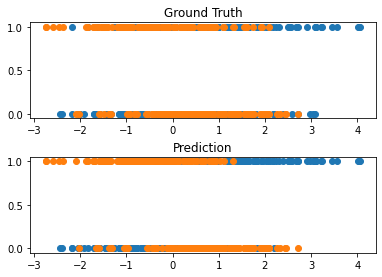

In [101]:
plt.subplot(2,1,1)
plt.scatter(X_test[:,0],y_test)
plt.scatter(X_test[:,1],y_test)
plt.title('Ground Truth')
plt.subplot(2,1,2)
plt.scatter(X_test[:,0],y_pred)
plt.scatter(X_test[:,1],y_pred)
plt.title('\nPrediction')
plt.subplots_adjust(left=0.1,bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

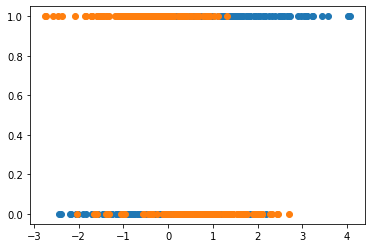

In [93]:
plt.scatter(X_test[:,0],y_pred)
plt.scatter(X_test[:,1],y_pred)